# OPTIMIZATION BY 5x2 CV - `DecisionTreeClassifier`

In this notebook we use `optuna` to optimize the `DecisionTreeClassifier`, this time using the 5x2 CV precision results as the objective.

In this case, we use the original S4 training sample to apply the 5x2 CV (i.e. without oversampling).

The hyperparameters of `DecisionTreeClassifier` to optimize are the following ones. The initial characteristics of the values to try are taken from the best values proposed by the previous basic optimization done when pre-selecting models:

- `max_depth`: integer $\in$ \[`1`, `25`\]. Rationale: the first optimization yielded $25$ (the lowest value in the grid). Even so, the tree was overfitting, so it is better to further reduce the tree depth.
- `min_samples_leaf`: integer $\in$ \[`5`, `20`\]. Rationale: the first optimization yielded $5$ (the lowest value in the grid). Even so, the tree was overfitting, so it is better to try also values larger than 5.
- `ccp_alpha`: float $\in$ \[`0.005`, `0.100`\]. Rationale: the first optimization yielded $0.005$. Even so, the tree was overfitting, so it is better to further prune the tree, which means larger values for `ccp_alpha`, which is the tuning parameter $\alpha$, governing the trade-off between the tree size and the goodness of fit to the data. Larger values of $\alpha$ imply smaller trees and lower goodness of fit to the data; lower values of $\alpha$ imply larger trees and higher goodness of fit to the data. As we were suffering from severe overfitting, we are interested in smalleer trees, even if the goodness of fit to the training sample decreases. That is to say, we are interested in higher values of $\alpha$ (`ccp_alhpa`).

At the moment, and in order to keep computation time under control, we leave the following parameters at the values suggested by the first basic optimization operation, assuming it was a good choice.

- `criterion`: `'entropy'`
- `max_features`: `None` (Note: we put this to `None`, because we feel `'sqrt'` and `'log2'` can introduce additional randomness to the models.


## Modules and configuration

### Modules

In [1]:
import pickle

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import precision_score, make_scorer, classification_report, confusion_matrix

import optuna

from matplotlib import pyplot as plt


### Configuration

In [2]:
RANDOM_STATE = 11 # For reproducibility

#S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest_OVERSAMPLED_n3.csv"
S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest.csv"
# Train/test set for S4 sample, all 112 features
S4_VALIDATION_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_Validation.csv"
# Validation set for S4 sample, all 112 features
CARMENES_SET_IN = "../data/DATASETS_ML/ML_02_DS_AfterImputing.csv"

REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"

OPT_DT_CLF_OUT = "../data/ML_MODELS/ML_pipeline_steps/Opt_DT_Classifier.pickle"
OPT_DT_CLF_OUT_COPY = "../data/ML_MODELS/Results_DecisionTree/Opt_DT_Classifier.pickle"

TR_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_Scaled_Train_Predictions.csv"
VAL_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_Scaled_Val_Predictions.csv"
CARMENES_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_Scaled_CARMENES_Predictions.csv"

OPTIMIZATION_TRIALS = "../data/ML_MODELS/Results_DecisionTree/DT_Scaled_Optuna_Trials.csv"
DECISION_TREE_FIG_OUT = "../data/ML_MODELS/Results_DecisionTree/DT_Scaled_DecisionTree_Image.jpg"

### Functions

In [31]:
def objective_cv_5x2(trial):
    # Defining hyper parameters:
    # Suggest maximum depth of tree:
    max_depth = trial.suggest_int("max_depth", 1, 8, step=1, log=False)
    # Suggest minimum samples in a leaf node:
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 5, 10, step=1, log=False)
    # Suggest the complexity parameter for Minimal Cost-Complexity Pruning:
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.005, 0.500, step=0.005, log=False)
    
    # Create the classifier:
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        ccp_alpha=ccp_alpha,
        criterion='entropy', max_features=None,
        splitter='best'
    )

    # Calculate the objective funcion (based on the 5 x 2 cross_validation score in the training set)
    # (Note: this function uses the global variable 'train_set'
    # Maybe not the best practice, but the intention is to prevent loading and
    # preprocessing the data each time the 'objective function is invoked')
    cv_results = []
    for fold in range(0,5): # Five runs
        run_results = []
        # Create 2-fold split:
        X_train, X_test, y_train, y_test = train_test_split(
            train_set[rel_features], train_set['Pulsating'],
            test_size=0.5, stratify=train_set['Pulsating'],
            random_state=RANDOM_STATE + fold
        )
        
        # Fit on X_train, y_train:
        clf.fit(X_train, y_train)
        # Predict values on X_test:
        y_test_pred = clf.predict(X_test)
        # Measure precision and add to the run results:
        new_precision = precision_score(y_test, y_test_pred, zero_division=0.0)
        run_results.append(new_precision)
        
        # Invert the 2-fold split
        X_train, X_test, y_train, y_test = X_test, X_train, y_test, y_train
        # Fit on (new, swapped) X_train, y_train:
        clf.fit(X_train, y_train)
        # Predict values on (new, swapped) X_test:
        y_test_pred = clf.predict(X_test)
        # Measure precision and add to the run results:
        new_precision = precision_score(y_test, y_test_pred, zero_division=0.0)
        run_results.append(new_precision)
        
        # Add the average to the overall results:
        cv_results.append(np.mean(run_results))
    
    # Create the crossvalidation result:
    cv_avg = np.mean(cv_results)

    # Return objective value (notice that we must tell 'optuna' to *maximize* the objective)
    return cv_avg    

In [32]:
def re_evaluate_model(model, X_train, y_train, X_val, y_val, refit=True):
    '''Reevaluates a model in the training and validation set'''
    if refit == True:
        model.fit(X_train, y_train)
    # Training score:
    y_train_pred = model.predict(X_train)
    tr_score = precision_score(y_train, y_train_pred, zero_division=0.0)
    # Validation score:
    y_val_pred = model.predict(X_val)
    val_score = precision_score(y_val, y_val_pred, zero_division=0.0)
    
    return {'train_score': tr_score, 'validation_score': val_score}

## Load data

### Load reliable features

In [33]:
REL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle'

In [34]:
rel_features = pickle.load(open(REL_FEATURES_IN, 'rb'))
print(rel_features)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_rel_phase3', '

In [35]:
len(rel_features)

48

### Load training data

In [36]:
S4_TRAIN_SET_IN

'../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest.csv'

In [37]:
tr_load = pd.read_csv(S4_TRAIN_SET_IN, sep=',', decimal='.')
tr_load.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00163,False,0.0,0.00,0.0,2.457444e+06,0.00,-0.674126,0.519174,0.466681,...,-0.712310,-1.187392,0.425026,-0.002305,0.495906,-0.537353,-0.028926,-0.262548,-0.135686,-0.705143
1,Star-00123,True,30.0,0.72,0.0,2.457401e+06,0.37,-1.626729,1.911247,-0.740748,...,0.040924,-1.110488,-0.289189,0.056551,0.555375,-0.699590,-0.292135,-0.013533,0.443673,-1.207278
2,Star-00022,False,0.0,0.00,0.0,2.457430e+06,0.00,-0.039057,-1.012107,0.013895,...,-0.943428,0.637603,-0.679383,0.020496,-0.496592,-0.001214,-0.101526,-0.011097,-0.293389,0.242263
3,Star-00708,False,0.0,0.00,0.0,2.459677e+06,0.00,-0.039057,1.632833,-0.514355,...,-1.091456,0.759880,-0.161363,-0.210930,0.135863,0.662121,-0.492481,0.015621,-0.724783,0.682494
4,Star-00484,False,0.0,0.00,0.0,2.457400e+06,0.00,0.596012,-0.176863,-1.042605,...,-0.696260,0.153752,0.936459,0.070402,-0.067689,-0.656553,-0.237337,-0.032597,-0.139141,-0.098080


#### Transform training data

Map the `Pulsating` column to `0` / `1`.

In [38]:
tr_load['Pulsating'] = tr_load['Pulsating'].map(lambda x: 1 if x == True else 0)
tr_load.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00163,0,0.0,0.00,0.0,2.457444e+06,0.00,-0.674126,0.519174,0.466681,...,-0.712310,-1.187392,0.425026,-0.002305,0.495906,-0.537353,-0.028926,-0.262548,-0.135686,-0.705143
1,Star-00123,1,30.0,0.72,0.0,2.457401e+06,0.37,-1.626729,1.911247,-0.740748,...,0.040924,-1.110488,-0.289189,0.056551,0.555375,-0.699590,-0.292135,-0.013533,0.443673,-1.207278
2,Star-00022,0,0.0,0.00,0.0,2.457430e+06,0.00,-0.039057,-1.012107,0.013895,...,-0.943428,0.637603,-0.679383,0.020496,-0.496592,-0.001214,-0.101526,-0.011097,-0.293389,0.242263
3,Star-00708,0,0.0,0.00,0.0,2.459677e+06,0.00,-0.039057,1.632833,-0.514355,...,-1.091456,0.759880,-0.161363,-0.210930,0.135863,0.662121,-0.492481,0.015621,-0.724783,0.682494
4,Star-00484,0,0.0,0.00,0.0,2.457400e+06,0.00,0.596012,-0.176863,-1.042605,...,-0.696260,0.153752,0.936459,0.070402,-0.067689,-0.656553,-0.237337,-0.032597,-0.139141,-0.098080


Select only the reliable features and target. Note the use of global variable here.

In [39]:
global train_set
train_set = tr_load[rel_features + ['Pulsating']].copy()
train_set.head()

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq1_rel_phase3,freq1_rel_phase4,freq2_rel_phase2,freq2_rel_phase3,freq2_rel_phase4,freq3_rel_phase2,freq3_rel_phase3,freq3_rel_phase4,freq_model_phi1_phi2,Pulsating
0,-0.674126,0.519174,0.466681,0.766297,1.786498,-0.304944,0.843252,0.189055,1.390901,0.462908,...,0.908818,1.305379,1.413989,0.174334,-0.188773,0.985693,-0.258841,-1.099919,-0.461571,0
1,-1.626729,1.911247,-0.740748,0.691384,0.168331,1.522002,1.166420,0.157675,0.019744,-0.192345,...,-1.224350,0.710232,-1.272791,1.617586,1.392776,0.260283,0.708876,1.030413,0.400968,1
2,-0.039057,-1.012107,0.013895,-0.357397,1.168762,-0.232282,-0.443941,-0.136007,-0.412519,-0.042766,...,0.882515,1.044322,-1.204443,-0.593335,-1.011092,0.592500,0.135213,0.725303,-0.319881,0
3,-0.039057,1.632833,-0.514355,0.166993,1.477630,-0.544204,-0.572606,-0.586661,-0.338658,-0.449412,...,-0.921750,-1.095322,-0.031960,-0.068737,1.152465,-0.672518,0.391616,-1.301501,0.559262,0
4,0.596012,-0.176863,-1.042605,-0.432310,0.242158,-0.277263,-0.498198,-0.370020,-0.451106,-0.321570,...,-0.057582,0.541269,1.529879,-0.689578,1.475290,-1.268004,1.297212,1.327633,-0.059789,0


In [40]:
print("Pulsating stars in training sample: %d" %len(train_set[train_set['Pulsating'] == 1]))

Pulsating stars in training sample: 78


In [41]:
print("Non-pulsating stars in training sample: %d" %len(train_set[train_set['Pulsating'] == 0]))

Non-pulsating stars in training sample: 672


### Load validation data

In [42]:
S4_VALIDATION_SET_IN

'../data/DATASETS_ML/S4_02_DS_AfterImputing_Validation.csv'

In [43]:
val_load = pd.read_csv(S4_VALIDATION_SET_IN, sep=',', decimal='.')
val_load.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00107,False,0.0,0.0,0.0,2.457430e+06,0.0,-0.991660,0.031948,0.542146,...,0.215296,-1.171010,-1.399418,0.202986,-0.550638,0.473838,-0.300629,-0.565171,-0.717831,-0.998997
1,Star-00868,False,0.0,0.0,0.0,2.457432e+06,0.0,-1.309194,-1.081711,1.825039,...,0.859339,-1.201677,-0.242453,-0.032886,-0.381893,4.479455,0.554354,0.946671,-2.945576,-0.390979
2,Star-00106,False,0.0,0.0,0.0,2.457404e+06,0.0,-0.356591,0.379966,0.844003,...,-0.619653,1.401153,0.280531,0.057394,-0.394560,0.012444,-0.506509,-0.073337,-0.019620,0.850942
3,Star-00120,False,0.0,0.0,0.0,2.457395e+06,0.0,-0.039057,0.519174,0.994931,...,-0.544944,-0.806949,-0.860069,0.186396,0.224160,-0.895172,-0.068329,-0.094626,0.283729,-1.018961
4,Star-00559,False,0.0,0.0,0.0,2.457441e+06,0.0,0.596012,-0.664089,-0.212498,...,0.600208,0.897864,0.219432,0.051864,-0.446379,-0.502312,-0.305140,-0.144503,0.889861,0.402366


#### Transform validation data

Map the `Pulsating` column to `0` / `1`.

In [44]:
val_load['Pulsating'] = val_load['Pulsating'].map(lambda x: 1 if x == True else 0)
val_load.head()

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,Star-00107,0,0.0,0.0,0.0,2.457430e+06,0.0,-0.991660,0.031948,0.542146,...,0.215296,-1.171010,-1.399418,0.202986,-0.550638,0.473838,-0.300629,-0.565171,-0.717831,-0.998997
1,Star-00868,0,0.0,0.0,0.0,2.457432e+06,0.0,-1.309194,-1.081711,1.825039,...,0.859339,-1.201677,-0.242453,-0.032886,-0.381893,4.479455,0.554354,0.946671,-2.945576,-0.390979
2,Star-00106,0,0.0,0.0,0.0,2.457404e+06,0.0,-0.356591,0.379966,0.844003,...,-0.619653,1.401153,0.280531,0.057394,-0.394560,0.012444,-0.506509,-0.073337,-0.019620,0.850942
3,Star-00120,0,0.0,0.0,0.0,2.457395e+06,0.0,-0.039057,0.519174,0.994931,...,-0.544944,-0.806949,-0.860069,0.186396,0.224160,-0.895172,-0.068329,-0.094626,0.283729,-1.018961
4,Star-00559,0,0.0,0.0,0.0,2.457441e+06,0.0,0.596012,-0.664089,-0.212498,...,0.600208,0.897864,0.219432,0.051864,-0.446379,-0.502312,-0.305140,-0.144503,0.889861,0.402366


Select only the reliable features and target.

In [45]:
val = val_load[rel_features + ['Pulsating']].copy()
val.head()

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq1_rel_phase3,freq1_rel_phase4,freq2_rel_phase2,freq2_rel_phase3,freq2_rel_phase4,freq3_rel_phase2,freq3_rel_phase3,freq3_rel_phase4,freq_model_phi1_phi2,Pulsating
0,-0.991660,0.031948,0.542146,1.740165,-0.298361,2.924506,1.112558,1.223343,-0.528719,-0.333528,...,-1.553810,-0.039531,-1.766924,0.105349,-0.914928,1.624409,1.041240,-1.287022,0.212829,0
1,-1.309194,-1.081711,1.825039,1.815078,-1.611050,-0.692478,0.439292,1.223343,1.528017,2.763725,...,-0.257974,-0.443062,0.117884,0.110252,-1.094708,-0.142404,0.174193,1.058664,-1.753975,0
2,-0.356591,0.379966,0.844003,0.166993,-1.147748,-0.480752,-0.473181,0.125210,-0.246422,0.578714,...,-0.244072,-1.117475,1.393767,-0.017646,-0.236540,0.981973,0.721607,-0.990852,-0.054942,0
3,-0.039057,0.519174,0.994931,1.065949,-1.379399,-0.348004,-0.310918,-0.224660,-0.136960,-0.068049,...,0.049026,1.533790,-0.885426,1.057050,0.254424,0.604281,-1.070993,-0.705840,-2.196394,0
4,0.596012,-0.664089,-0.212498,0.391732,0.087724,1.196750,2.120285,1.085438,0.930900,0.226927,...,-0.834589,0.906258,1.467923,0.111756,-0.662832,-0.936044,0.525532,-1.277372,-0.605419,0


In [46]:
print("Pulsating stars in validation sample: %d" %len(val[val['Pulsating'] == 1]))

Pulsating stars in validation sample: 26


In [47]:
print("Non-pulsating stars in validation sample: %d" %len(val[val['Pulsating'] == 0]))

Non-pulsating stars in validation sample: 224


### Load CARMENES data

In [48]:
CARMENES_SET_IN

'../data/DATASETS_ML/ML_02_DS_AfterImputing.csv'

In [49]:
carm = pd.read_csv(CARMENES_SET_IN, sep=',', decimal='.')
carm.head()

,Karmn,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,J23505-095,0.278478,-0.594485,0.013895,-0.956701,0.396592,-0.582246,-0.695467,0.903654,-0.497556,...,-1.344237,0.307975,2.250000,0.336808,-0.001346,1.812800,-0.802968,-0.248463,-2.393587,0.183519
1,J23492+024,-0.674126,-0.733692,-0.438891,-0.057745,0.473809,-0.347436,-0.322543,1.312483,-0.153626,...,-2.251395,1.650742,-4.235033,0.118526,-0.244276,0.604280,-0.787328,-0.394400,-1.810785,1.600874
2,J23431+365,0.596012,-0.107259,0.542146,1.740165,-0.993314,-0.573237,-0.710438,-0.638376,-0.528719,...,0.178298,-1.062289,0.366300,0.121669,-0.255425,-0.788734,-0.490843,-0.667690,-0.338895,-1.116797
3,J23419+441,0.278478,1.354418,0.240288,1.140862,-0.993314,-0.281692,-0.412485,-0.559694,-0.332839,...,-2.029837,0.290144,0.829992,-0.008235,-0.235705,0.526272,-0.801627,-0.339110,-1.928617,0.555949
4,J23381-162,-0.039057,-0.385674,-0.891677,-0.657049,1.477630,0.003096,0.886923,0.217009,0.990671,...,-0.842653,0.846232,-0.199704,0.150270,-0.191291,0.634827,-0.436603,-0.188157,0.037966,0.228970


## Optimize with `optuna`

### Define objective function

See 'Functions' subsection.

### Create study

In [50]:
study = optuna.create_study(direction="maximize")

### Run many trials of the `optuna` study

We first set the verbosity to low values.

In [51]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

We start with $100$ trials:

In [52]:
study.optimize(objective_cv_5x2, n_trials=100, show_progress_bar=True)

C:\Users\ciroe\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

More trials:

In [53]:
study.optimize(objective_cv_5x2, n_trials=400, show_progress_bar=True)

C:\Users\ciroe\anaconda3\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/400 [00:00<?, ?it/s]

### `optuna` results analysis

In [95]:
study.best_params

{'max_depth': 8, 'min_samples_leaf': 10, 'ccp_alpha': 0.005}

In [55]:
study.best_value

0.08595365418894832

In [56]:
optuna.visualization.is_available()

False

### Create the optimization space coverage

In [57]:
opt_space_coverage = study.trials_dataframe()
opt_space_coverage

,number,value,datetime_start,datetime_complete,duration,params_ccp_alpha,params_max_depth,params_min_samples_leaf,state
0,0,0.000000,2023-03-01 18:02:00.921317,2023-03-01 18:02:00.975200,0 days 00:00:00.053883,0.335,1,8,COMPLETE
1,1,0.000000,2023-03-01 18:02:00.976197,2023-03-01 18:02:01.054989,0 days 00:00:00.078792,0.095,4,5,COMPLETE
2,2,0.000000,2023-03-01 18:02:01.055990,2023-03-01 18:02:01.123802,0 days 00:00:00.067812,0.420,3,7,COMPLETE
3,3,0.000000,2023-03-01 18:02:01.124811,2023-03-01 18:02:01.188629,0 days 00:00:00.063818,0.190,3,9,COMPLETE
4,4,0.000000,2023-03-01 18:02:01.189630,2023-03-01 18:02:01.270417,0 days 00:00:00.080787,0.470,5,10,COMPLETE
...,...,...,...,...,...,...,...,...,...
495,495,0.034500,2023-03-01 18:02:56.253900,2023-03-01 18:02:56.389537,0 days 00:00:00.135637,0.015,8,9,COMPLETE
496,496,0.000000,2023-03-01 18:02:56.390534,2023-03-01 18:02:56.536146,0 days 00:00:00.145612,0.025,8,9,COMPLETE
497,497,0.081276,2023-03-01 18:02:56.537143,2023-03-01 18:02:56.667793,0 days 00:00:00.130650,0.005,8,9,COMPLETE
498,498,0.034500,2023-03-01 18:02:56.668809,2023-03-01 18:02:56.798475,0 days 00:00:00.129666,0.015,8,9,COMPLETE


### Re-evaluate the model on the full training set and validation set

In [58]:
new_results = re_evaluate_model(
    DecisionTreeClassifier(
        max_depth=study.best_params['max_depth'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        ccp_alpha=study.best_params['ccp_alpha'],
        criterion='entropy', max_features=None,
        splitter='best'
    ),
    X_train=train_set[rel_features], y_train=train_set['Pulsating'],
    X_val=val[rel_features], y_val=val['Pulsating'],
    refit=True
)
new_results

{'train_score': 0.5333333333333333, 'validation_score': 0.3333333333333333}

## New classifier with the optimized parameters

### Classifier definition

With the parameters optimized by `optuna`. 

In [59]:
new_clf = DecisionTreeClassifier(
    max_depth=study.best_params['max_depth'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    ccp_alpha=study.best_params['ccp_alpha'],
    criterion='entropy', max_features=None,
    splitter='best'
)

### Classifier fit

In [60]:
new_clf.fit(train_set[rel_features], train_set['Pulsating'])

DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy', max_depth=8,
                       min_samples_leaf=10)

### Classifier performance overview (in training/test and validation samples)

#### Precision

In [61]:
new_precision_training = precision_score(train_set['Pulsating'], new_clf.predict(train_set[rel_features]))
print("Precision in training sample: %.2f" %new_precision_training)

Precision in training sample: 0.53


In [62]:
new_precision_validation = precision_score(val['Pulsating'], new_clf.predict(val[rel_features]))
print("Precision in validation sample: %.2f" %new_precision_validation)

Precision in validation sample: 0.33


#### Classification reports

In [63]:
print(classification_report(train_set['Pulsating'], new_clf.predict(train_set[rel_features])))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       672
           1       0.53      0.10      0.17        78

    accuracy                           0.90       750
   macro avg       0.72      0.55      0.56       750
weighted avg       0.87      0.90      0.86       750



In [64]:
print(classification_report(val['Pulsating'], new_clf.predict(val[rel_features])))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       224
           1       0.33      0.04      0.07        26

    accuracy                           0.89       250
   macro avg       0.62      0.51      0.51       250
weighted avg       0.84      0.89      0.85       250



#### Confusion matrices

In [65]:
confusion_matrix(train_set['Pulsating'], new_clf.predict(train_set[rel_features]))

array([[665,   7],
       [ 70,   8]], dtype=int64)

In [66]:
confusion_matrix(val['Pulsating'], new_clf.predict(val[rel_features]))

array([[222,   2],
       [ 25,   1]], dtype=int64)

**OBSERVATION:** Ok, we have managed to raise the precision in validation sample a little bit, but **the recall is very low** (only 1 of the 26 originally pulsating stars are correctly classified).

### Predictions for training/test set

In [67]:
tr_pred = new_clf.predict(train_set[rel_features])
print(tr_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [68]:
tr_pred_proba = new_clf.predict_proba(train_set[rel_features])
print(tr_pred_proba)

[[1.         0.        ]
 [0.73333333 0.26666667]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.57142857 0.42857143]]


In [69]:
tr_predictions = pd.concat([
    tr_load[['ID', 'Pulsating']],
    pd.DataFrame({'Pulsation predicted': tr_pred}),
    pd.DataFrame({'Pulsation probability': tr_pred_proba[:,1]})],
    axis=1)
tr_predictions.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability
0,Star-00163,0,0,0.000000
1,Star-00123,1,0,0.266667
2,Star-00022,0,0,0.000000
3,Star-00708,0,0,0.000000
4,Star-00484,0,0,0.000000


In [70]:
tr_predictions[tr_predictions['Pulsation predicted'] == 1]

,ID,Pulsating,Pulsation predicted,Pulsation probability
18,Star-00573,1,1,0.533333
30,Star-00301,0,1,0.533333
48,Star-00004,1,1,0.533333
179,Star-00388,1,1,0.533333
238,Star-00438,0,1,0.533333
321,Star-00185,1,1,0.533333
331,Star-00609,0,1,0.533333
333,Star-00213,1,1,0.533333
444,Star-00077,0,1,0.533333
474,Star-00356,1,1,0.533333


In [71]:
len(tr_predictions[tr_predictions['Pulsation predicted'] == 1])

15

### Predictions for validation set

In [72]:
val_pred = new_clf.predict(val_load[rel_features])
print(val_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [73]:
val_pred_proba = new_clf.predict_proba(val_load[rel_features])
print(val_pred_proba[:10])

[[0.63636364 0.36363636]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.99099099 0.00900901]
 [0.73333333 0.26666667]
 [1.         0.        ]
 [0.92307692 0.07692308]
 [0.63636364 0.36363636]
 [0.99099099 0.00900901]]


In [74]:
val_predictions = pd.concat([
    val_load[['ID', 'Pulsating']],
    pd.DataFrame({'Pulsation predicted': val_pred}),
    pd.DataFrame({'Pulsation probability': val_pred_proba[:,1]})],
    axis=1)
val_predictions.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability
0,Star-00107,0,0,0.363636
1,Star-00868,0,0,0.000000
2,Star-00106,0,0,0.000000
3,Star-00120,0,0,0.000000
4,Star-00559,0,0,0.009009


In [75]:
val_predictions[val_predictions['Pulsation predicted'] == 1]

,ID,Pulsating,Pulsation predicted,Pulsation probability
103,Star-00636,1,1,0.533333
122,Star-00383,0,1,0.533333
146,Star-00292,0,1,0.533333


In [76]:
len(val_predictions[val_predictions['Pulsation predicted'] == 1])

3

### Predictions for CARMENES

In [77]:
carm_pred = new_clf.predict(carm[rel_features])
print(carm_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [78]:
carm_pred_proba = new_clf.predict_proba(carm[rel_features])
print(carm_pred_proba[:,1])

[0.00900901 0.00900901 0.         0.         0.         0.26666667
 0.26666667 0.07692308 0.26666667 0.07692308 0.26666667 0.
 0.00900901 0.00900901 0.26666667 0.         0.00900901 0.00900901
 0.42857143 0.09677419 0.         0.         0.125      0.26666667
 0.         0.26666667 0.125      0.42857143 0.28571429 0.48387097
 0.         0.09677419 0.         0.00900901 0.09677419 0.
 0.         0.         0.00900901 0.         0.00900901 0.
 0.00900901 0.125      0.         0.         0.         0.125
 0.26666667 0.48387097 0.09677419 0.         0.         0.26666667
 0.28571429 0.42857143 0.         0.42857143 0.07692308 0.
 0.         0.48387097 0.48387097 0.         0.         0.
 0.         0.42857143 0.26666667 0.53333333 0.         0.
 0.         0.         0.         0.         0.00900901 0.
 0.         0.125      0.         0.         0.48387097 0.48387097
 0.00900901 0.00900901 0.2        0.07692308 0.         0.42857143
 0.         0.         0.         0.         0.         

In [79]:
carm_predictions = pd.DataFrame(
    {'Karmn': carm['Karmn'],
     'Pulsation predicted': carm_pred,
     'Pulsation probability': carm_pred_proba[:,1]
    }
)
carm_predictions.head()

,Karmn,Pulsation predicted,Pulsation probability
0,J23505-095,0,0.009009
1,J23492+024,0,0.009009
2,J23431+365,0,0.000000
3,J23419+441,0,0.000000
4,J23381-162,0,0.000000


In [80]:
carm_predictions[carm_predictions['Pulsation predicted'] == 1]

,Karmn,Pulsation predicted,Pulsation probability
69,J16581+257,1,0.533333
161,J08126-215,1,0.533333


### Classifier characteristics

#### Feature importance

In [81]:
new_clf.feature_importances_

array([0.        , 0.05335173, 0.04745253, 0.        , 0.03747354,
       0.        , 0.05515932, 0.        , 0.        , 0.        ,
       0.        , 0.0316615 , 0.03164756, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05959072,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08915158, 0.        , 0.        , 0.03160099,
       0.        , 0.        , 0.03114912, 0.09328862, 0.04902369,
       0.02875651, 0.07167629, 0.08097533, 0.07631868, 0.        ,
       0.        , 0.08848369, 0.04323861])

In [82]:
new_clf.feature_names_in_

array(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val',
       'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10',
       'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50',
       'cad_probs_100', 'cad_probs_500', 'cad_probs_1000',
       'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000',
       'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000',
       'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med',
       'cads_std', 'med_double_to_single_step', 'n_epochs',
       'std_double_to_single_step', 'total_time', 'percent_beyond_1_std',
       'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4

And the relevant features are:

In [83]:
for (a,b) in zip(new_clf.feature_names_in_, new_clf.feature_importances_):
    print("F: %s, imp: %.2f" %(a, b))

F: all_times_nhist_numpeaks, imp: 0.00
F: all_times_nhist_peak1_bin, imp: 0.05
F: all_times_nhist_peak2_bin, imp: 0.05
F: all_times_nhist_peak3_bin, imp: 0.00
F: all_times_nhist_peak4_bin, imp: 0.04
F: all_times_nhist_peak_1_to_2, imp: 0.00
F: all_times_nhist_peak_1_to_3, imp: 0.06
F: all_times_nhist_peak_1_to_4, imp: 0.00
F: all_times_nhist_peak_2_to_3, imp: 0.00
F: all_times_nhist_peak_2_to_4, imp: 0.00
F: all_times_nhist_peak_3_to_4, imp: 0.00
F: all_times_nhist_peak_val, imp: 0.03
F: avg_double_to_single_step, imp: 0.03
F: cad_probs_1, imp: 0.00
F: cad_probs_10, imp: 0.00
F: cad_probs_20, imp: 0.00
F: cad_probs_30, imp: 0.00
F: cad_probs_40, imp: 0.00
F: cad_probs_50, imp: 0.00
F: cad_probs_100, imp: 0.00
F: cad_probs_500, imp: 0.00
F: cad_probs_1000, imp: 0.00
F: cad_probs_5000, imp: 0.00
F: cad_probs_10000, imp: 0.00
F: cad_probs_50000, imp: 0.06
F: cad_probs_100000, imp: 0.00
F: cad_probs_500000, imp: 0.00
F: cad_probs_1000000, imp: 0.00
F: cad_probs_5000000, imp: 0.00
F: cad_pr

In [84]:
feature_relevances = [(a, b) for (a, b) in zip(new_clf.feature_names_in_, new_clf.feature_importances_)]
feature_relevances

[('all_times_nhist_numpeaks', 0.0),
 ('all_times_nhist_peak1_bin', 0.053351732839712354),
 ('all_times_nhist_peak2_bin', 0.04745253255262875),
 ('all_times_nhist_peak3_bin', 0.0),
 ('all_times_nhist_peak4_bin', 0.0374735424302233),
 ('all_times_nhist_peak_1_to_2', 0.0),
 ('all_times_nhist_peak_1_to_3', 0.055159316528155804),
 ('all_times_nhist_peak_1_to_4', 0.0),
 ('all_times_nhist_peak_2_to_3', 0.0),
 ('all_times_nhist_peak_2_to_4', 0.0),
 ('all_times_nhist_peak_3_to_4', 0.0),
 ('all_times_nhist_peak_val', 0.031661495131439336),
 ('avg_double_to_single_step', 0.031647560604420526),
 ('cad_probs_1', 0.0),
 ('cad_probs_10', 0.0),
 ('cad_probs_20', 0.0),
 ('cad_probs_30', 0.0),
 ('cad_probs_40', 0.0),
 ('cad_probs_50', 0.0),
 ('cad_probs_100', 0.0),
 ('cad_probs_500', 0.0),
 ('cad_probs_1000', 0.0),
 ('cad_probs_5000', 0.0),
 ('cad_probs_10000', 0.0),
 ('cad_probs_50000', 0.059590721245794245),
 ('cad_probs_100000', 0.0),
 ('cad_probs_500000', 0.0),
 ('cad_probs_1000000', 0.0),
 ('cad_pr

In [85]:
relevant_features = sorted([(elem[0], elem[1]) for elem in feature_relevances if elem[1] > 0.0],
                           key=lambda x: x[1], reverse=True)
relevant_features

[('freq1_rel_phase2', 0.09328862005145015),
 ('cads_med', 0.08915158085255727),
 ('freq3_rel_phase4', 0.08848368750165665),
 ('freq2_rel_phase3', 0.08097533036757894),
 ('freq2_rel_phase4', 0.07631867650916775),
 ('freq2_rel_phase2', 0.07167629217565205),
 ('cad_probs_50000', 0.059590721245794245),
 ('all_times_nhist_peak_1_to_3', 0.055159316528155804),
 ('all_times_nhist_peak1_bin', 0.053351732839712354),
 ('freq1_rel_phase3', 0.04902369268111699),
 ('all_times_nhist_peak2_bin', 0.04745253255262875),
 ('freq_model_phi1_phi2', 0.043238609453108104),
 ('all_times_nhist_peak4_bin', 0.0374735424302233),
 ('all_times_nhist_peak_val', 0.031661495131439336),
 ('avg_double_to_single_step', 0.031647560604420526),
 ('n_epochs', 0.03160098627192034),
 ('percent_beyond_1_std', 0.03114911737675533),
 ('freq1_rel_phase4', 0.028756505426662093)]

In [86]:
sum([elem[1] for elem in relevant_features])

0.9999999999999998

#### Tree visualization

In [87]:
new_clf.get_depth()

8

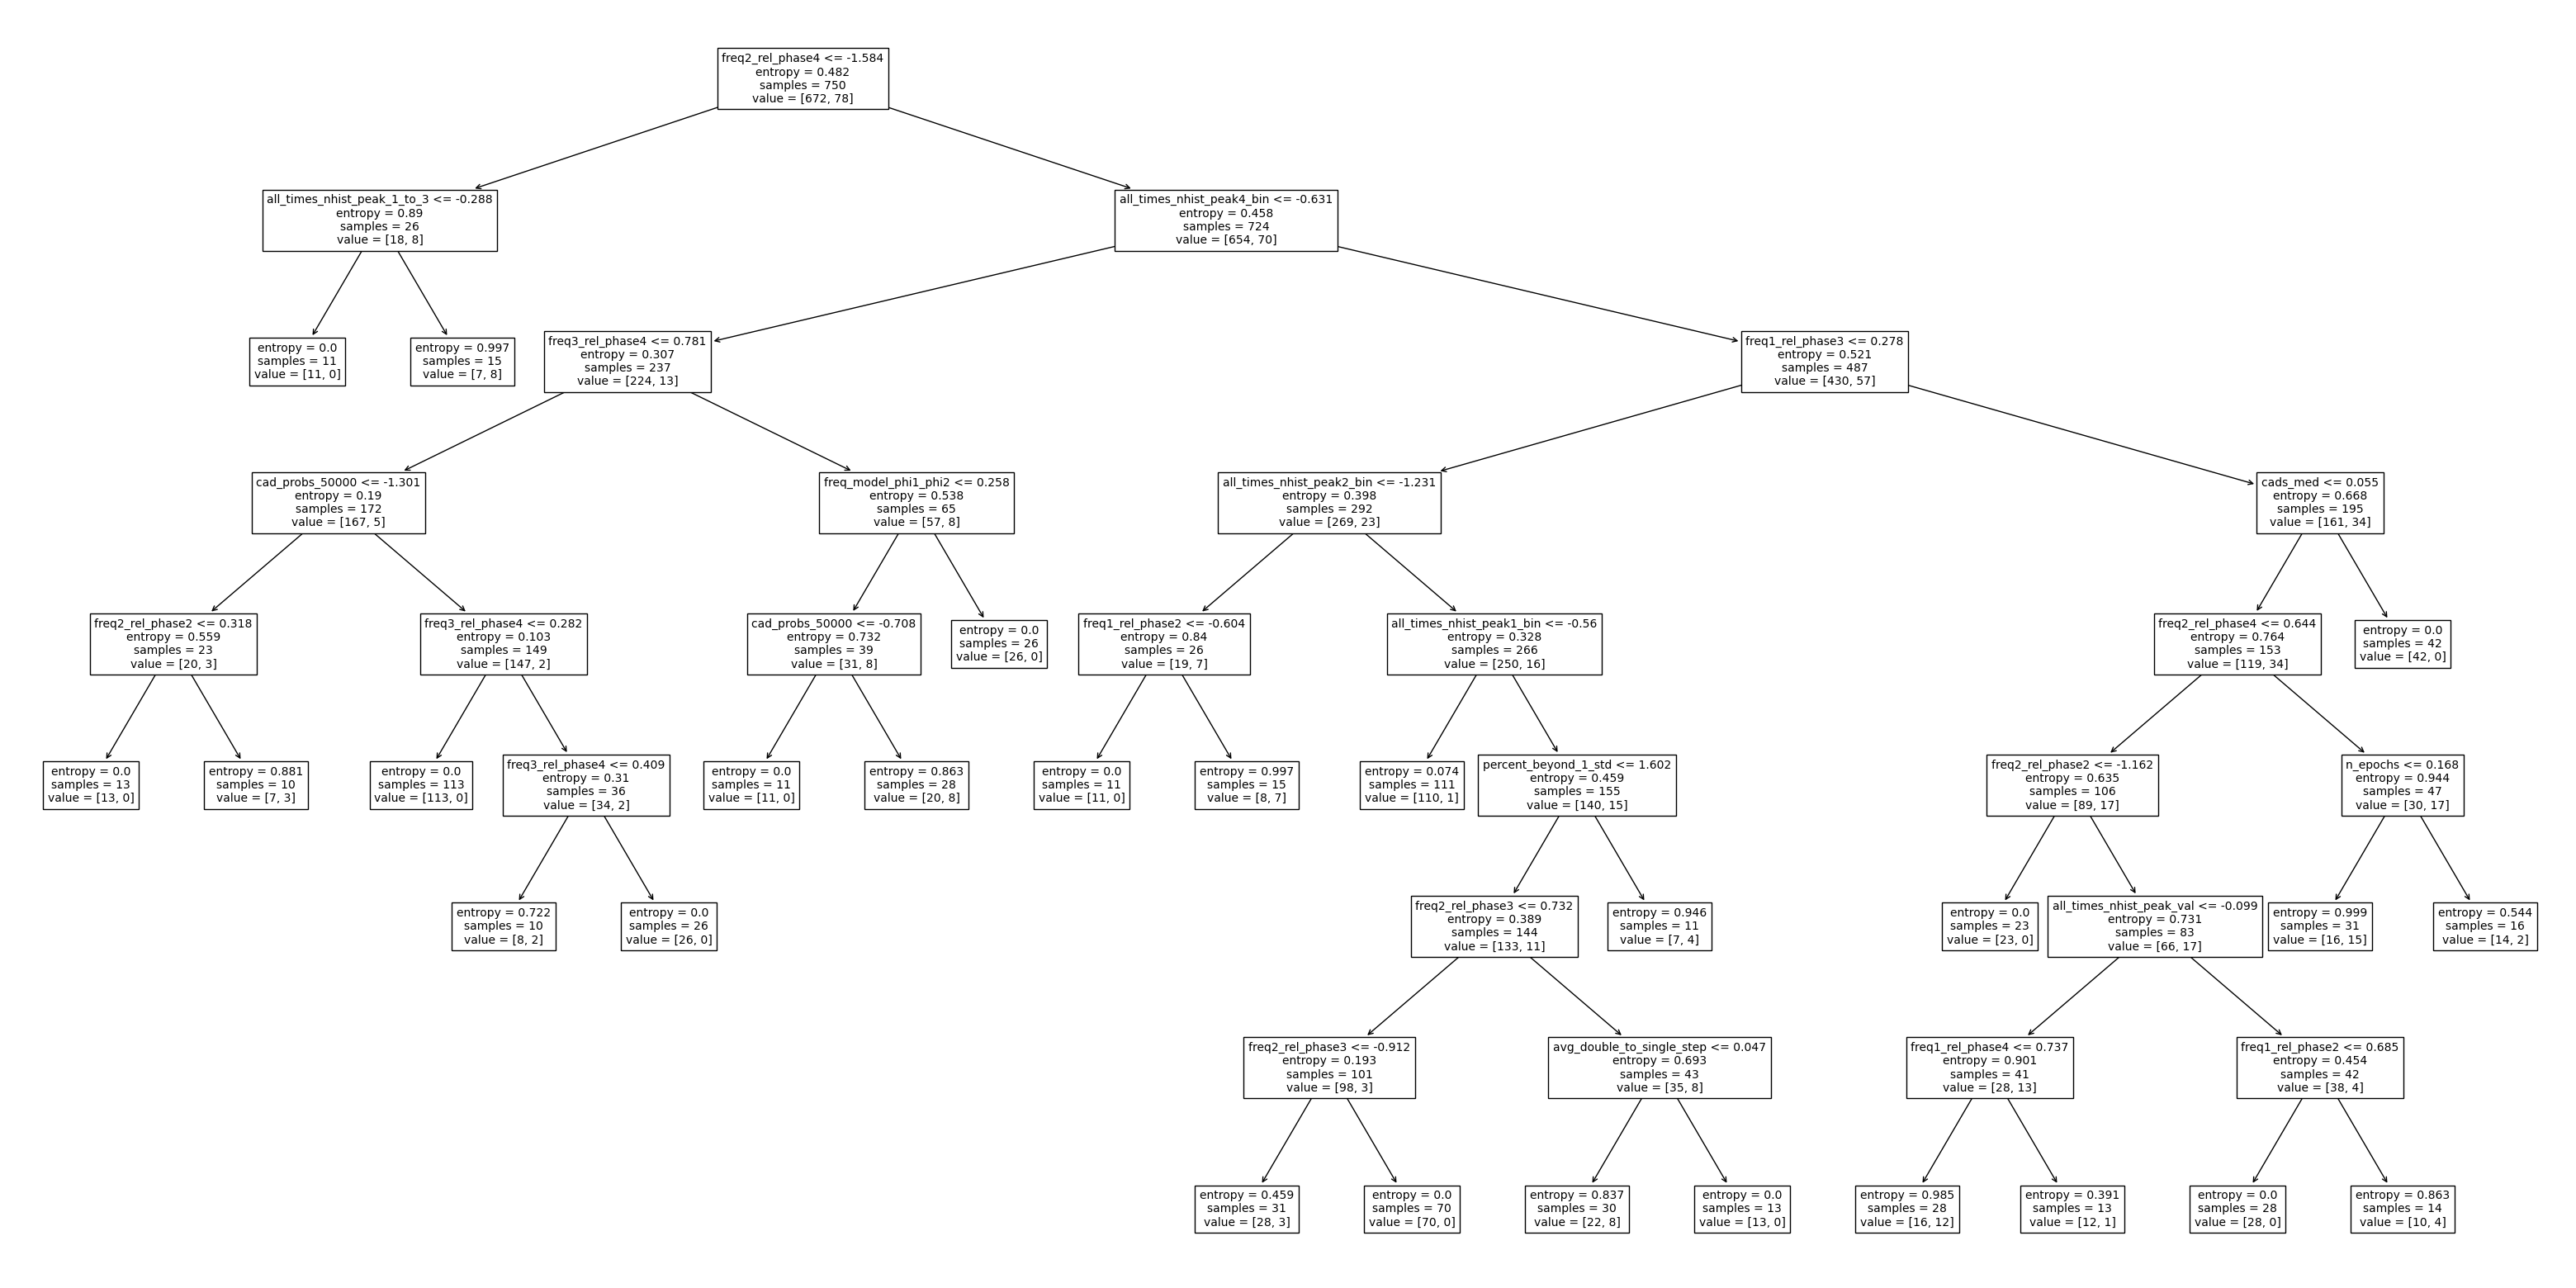

In [91]:
plt.figure(figsize=(40,20))
plot_tree(new_clf, feature_names=new_clf.feature_names_in_, fontsize=10);
#plt.savefig(DECISION_TREE_FIG_OUT, format='jpg')

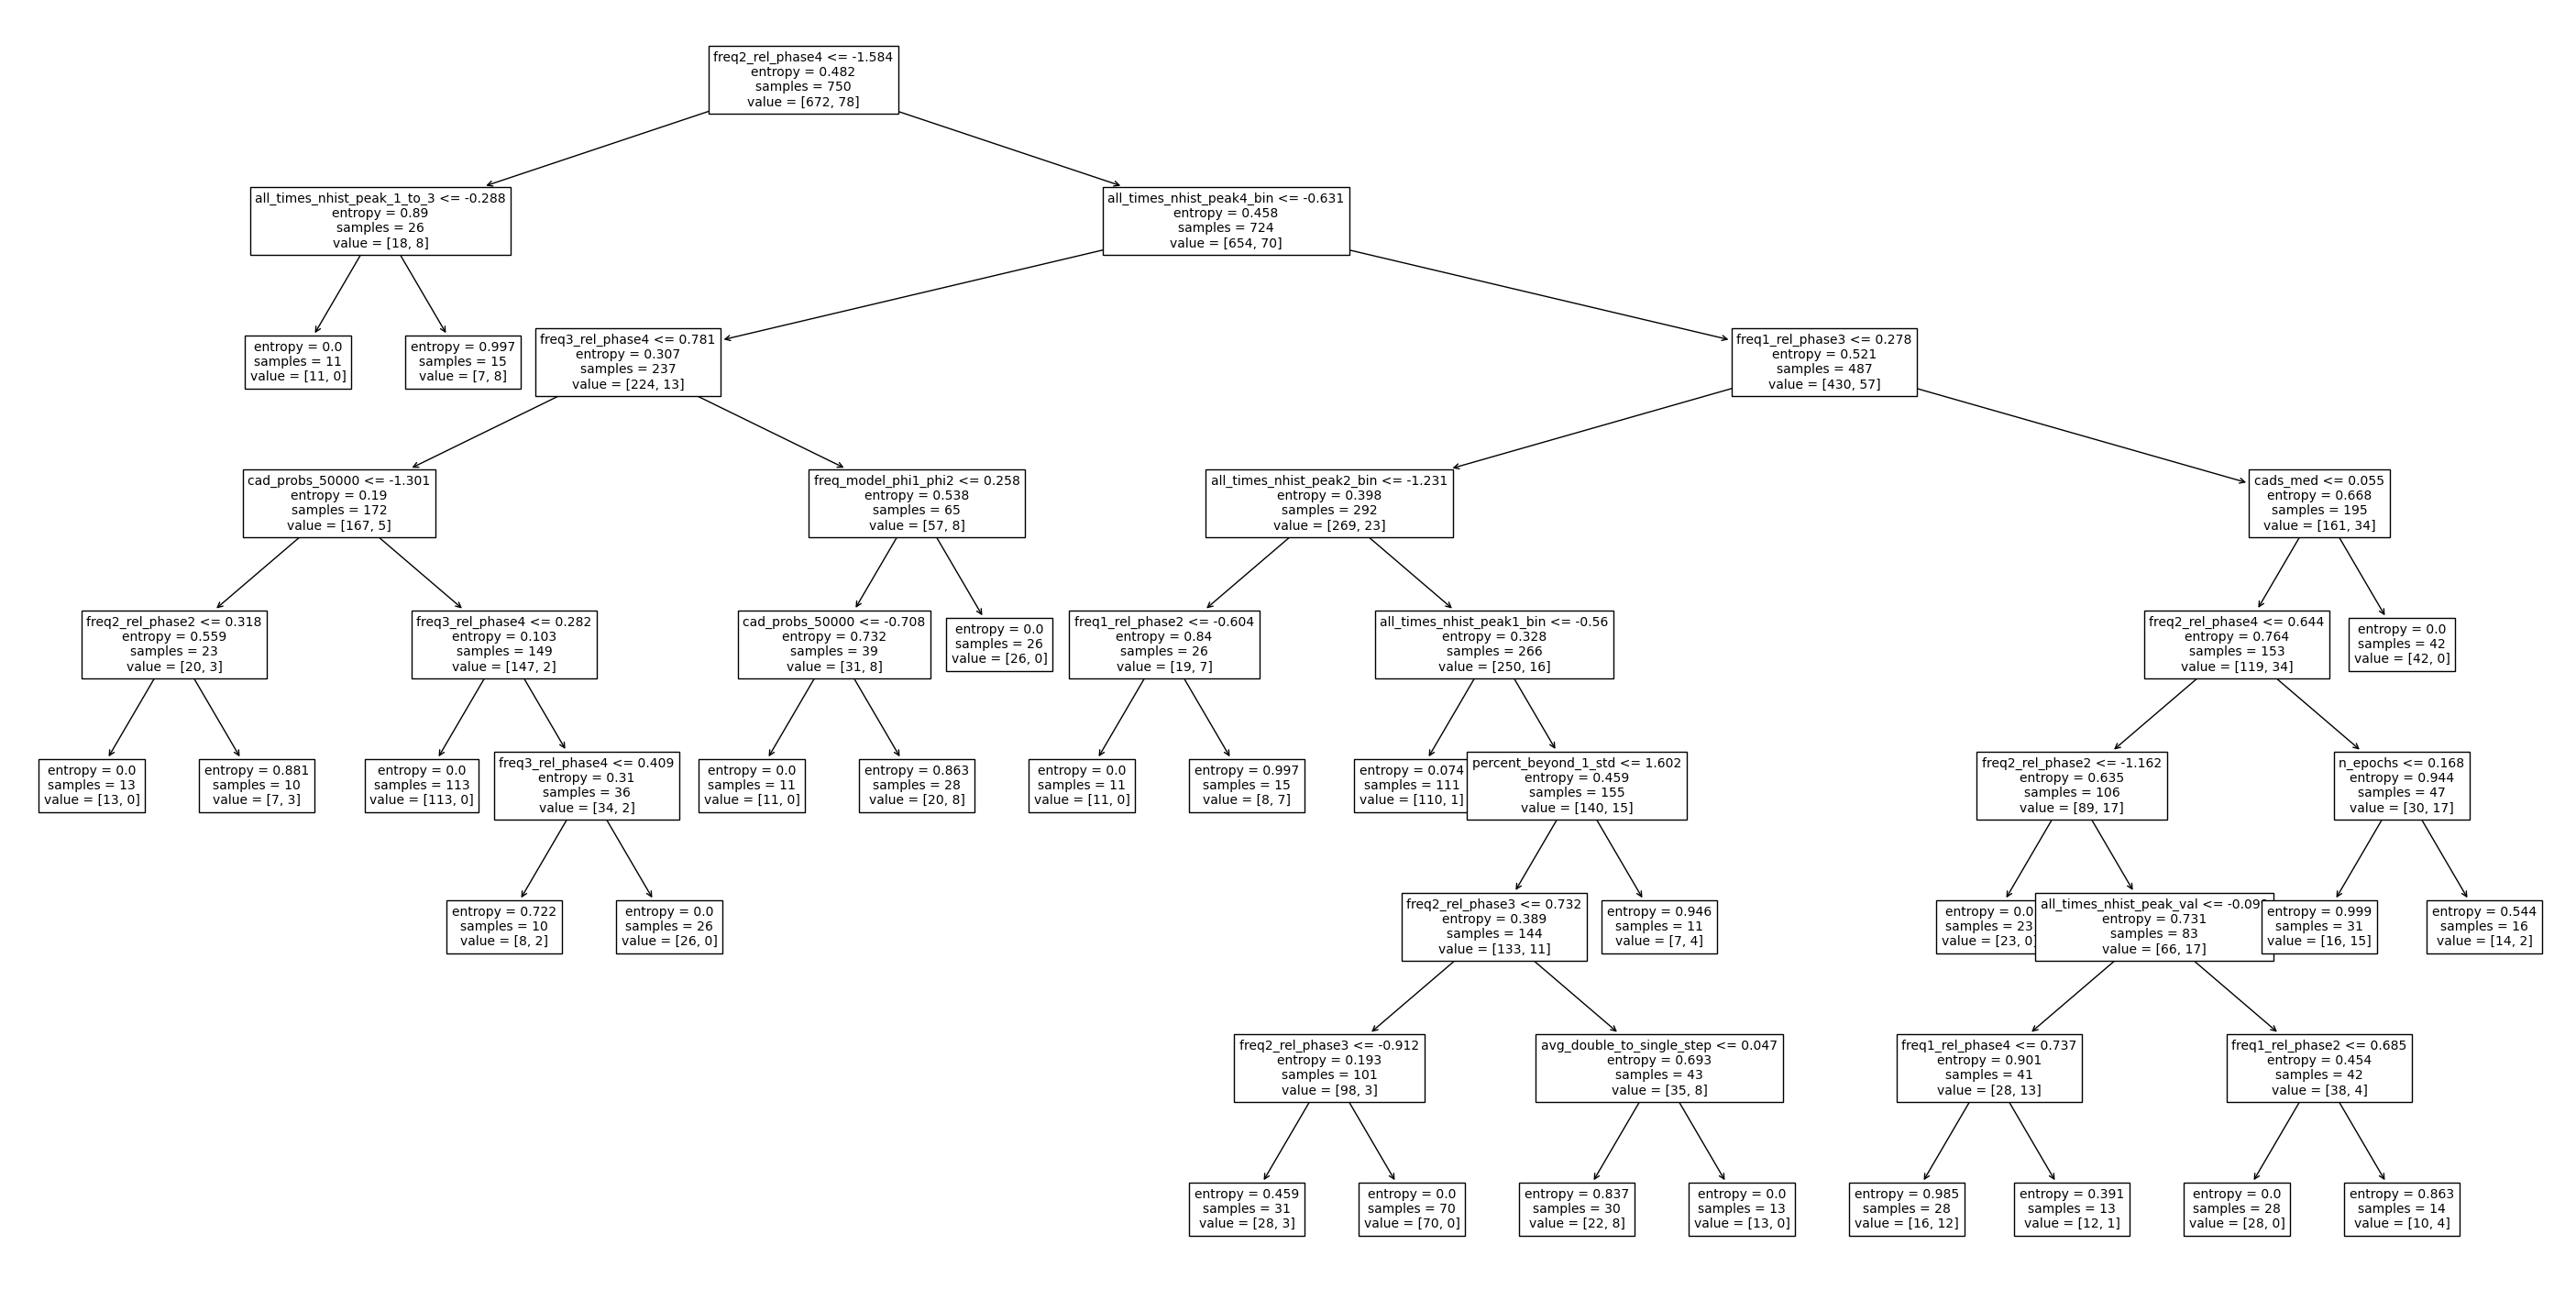

In [96]:
plt.figure(figsize=(36,18))
plot_tree(new_clf, feature_names=new_clf.feature_names_in_, fontsize=10)
plt.savefig(DECISION_TREE_FIG_OUT, format='jpg')

#### Decision paths for pulsating detections

##### Training/test sample

In [97]:
# Modified from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
print("DECISION PATHS FOR TRAINING/TEST SAMPLE STARS DETECTED AS PULSATING:")

n_nodes = new_clf.tree_.node_count
children_left = new_clf.tree_.children_left
children_right = new_clf.tree_.children_right
feature = new_clf.tree_.feature
threshold = new_clf.tree_.threshold

feature_names = new_clf.feature_names_in_

X_tr_pulsating = train_set.loc[tr_predictions['Pulsation predicted'] == 1, rel_features] \
    .reset_index(drop=True)
star_names = tr_load.loc[tr_predictions['Pulsation predicted'] == 1, ['ID']] \
    .reset_index(drop=True)

node_indicator = new_clf.decision_path(X_tr_pulsating)
leaf_id = new_clf.apply(X_tr_pulsating)

for sample_id in range(0, len(X_tr_pulsating)):
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    #print("Rules used to predict sample {id}:\n".format(id=sample_id))
    print("\nRules used to predict sample {id}, {star_id}:" \
          .format(id=sample_id, star_id=star_names.loc[sample_id, 'ID']))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_tr_pulsating.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "\tdecision node {node} : (X_tr_pulsating[{sample}, {f_name} ({feature})] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                f_name=feature_names[feature[node_id]],
                value=X_tr_pulsating.iloc[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

DECISION PATHS FOR TRAINING/TEST SAMPLE STARS DETECTED AS PULSATING:

Rules used to predict sample 0, Star-00573:
	decision node 0 : (X_tr_pulsating[0, freq2_rel_phase4 (43)] = -1.6698766039754052) <= -1.5843476057052612)
	decision node 1 : (X_tr_pulsating[0, all_times_nhist_peak_1_to_3 (6)] = 0.1969167498285861) > -0.28786836564540863)

Rules used to predict sample 1, Star-00301:
	decision node 0 : (X_tr_pulsating[1, freq2_rel_phase4 (43)] = -1.661799791884184) <= -1.5843476057052612)
	decision node 1 : (X_tr_pulsating[1, all_times_nhist_peak_1_to_3 (6)] = 0.5200843605750554) > -0.28786836564540863)

Rules used to predict sample 2, Star-00004:
	decision node 0 : (X_tr_pulsating[2, freq2_rel_phase4 (43)] = -1.5880156871533215) <= -1.5843476057052612)
	decision node 1 : (X_tr_pulsating[2, all_times_nhist_peak_1_to_3 (6)] = -0.2878346662911179) > -0.28786836564540863)

Rules used to predict sample 3, Star-00388:
	decision node 0 : (X_tr_pulsating[3, freq2_rel_phase4 (43)] = -1.5901612985

##### Validation sample

In [98]:
# Modified from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
print("DECISION PATHS FOR VALIDATION SAMPLE STARS DETECTED AS PULSATING:")

n_nodes = new_clf.tree_.node_count
children_left = new_clf.tree_.children_left
children_right = new_clf.tree_.children_right
feature = new_clf.tree_.feature
threshold = new_clf.tree_.threshold

feature_names = new_clf.feature_names_in_

X_val_pulsating = val.loc[val_predictions['Pulsation predicted'] == 1, rel_features] \
    .reset_index(drop=True)
star_names = val_load.loc[val_predictions['Pulsation predicted'] == 1, ['ID']] \
    .reset_index(drop=True)

node_indicator = new_clf.decision_path(X_val_pulsating)
leaf_id = new_clf.apply(X_val_pulsating)

for sample_id in range(0, len(X_val_pulsating)):
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    #print("Rules used to predict sample {id}:\n".format(id=sample_id))
    print("\nRules used to predict sample {id}, {star_id}:" \
          .format(id=sample_id, star_id=star_names.loc[sample_id, 'ID']))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_val_pulsating.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "\tdecision node {node} : (X_val_pulsating[{sample}, {f_name} ({feature})] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                f_name=feature_names[feature[node_id]],
                value=X_val_pulsating.iloc[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

DECISION PATHS FOR VALIDATION SAMPLE STARS DETECTED AS PULSATING:

Rules used to predict sample 0, Star-00636:
	decision node 0 : (X_val_pulsating[0, freq2_rel_phase4 (43)] = -1.6333741848800336) <= -1.5843476057052612)
	decision node 1 : (X_val_pulsating[0, all_times_nhist_peak_1_to_3 (6)] = 1.651170998187698) > -0.28786836564540863)

Rules used to predict sample 1, Star-00383:
	decision node 0 : (X_val_pulsating[1, freq2_rel_phase4 (43)] = -1.6889889262931743) <= -1.5843476057052612)
	decision node 1 : (X_val_pulsating[1, all_times_nhist_peak_1_to_3 (6)] = 1.4274395753632192) > -0.28786836564540863)

Rules used to predict sample 2, Star-00292:
	decision node 0 : (X_val_pulsating[2, freq2_rel_phase4 (43)] = -1.6387512280802614) <= -1.5843476057052612)
	decision node 1 : (X_val_pulsating[2, all_times_nhist_peak_1_to_3 (6)] = -0.2878346662911179) > -0.28786836564540863)


##### CARMENES sample

In [99]:
# Modified from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
print("DECISION PATHS FOR CARMENES SAMPLE STARS DETECTED AS PULSATING:")

n_nodes = new_clf.tree_.node_count
children_left = new_clf.tree_.children_left
children_right = new_clf.tree_.children_right
feature = new_clf.tree_.feature
threshold = new_clf.tree_.threshold

feature_names = new_clf.feature_names_in_

X_carm_pulsating = carm.loc[carm_predictions['Pulsation predicted'] == 1, rel_features] \
    .reset_index(drop=True)
star_names = carm.loc[carm_predictions['Pulsation predicted'] == 1, ['Karmn']] \
    .reset_index(drop=True)

node_indicator = new_clf.decision_path(X_carm_pulsating)
leaf_id = new_clf.apply(X_carm_pulsating)

for sample_id in range(0, len(X_carm_pulsating)):
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    #print("Rules used to predict sample {id}:\n".format(id=sample_id))
    print("\nRules used to predict sample {id}, {star_id}:" \
          .format(id=sample_id, star_id=star_names.loc[sample_id, 'Karmn']))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_carm_pulsating.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "\tdecision node {node} : (X_carm_pulsating[{sample}, {f_name} ({feature})] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                f_name=feature_names[feature[node_id]],
                value=X_carm_pulsating.iloc[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

DECISION PATHS FOR CARMENES SAMPLE STARS DETECTED AS PULSATING:

Rules used to predict sample 0, J16581+257:
	decision node 0 : (X_carm_pulsating[0, freq2_rel_phase4 (43)] = -1.5975389699479376) <= -1.5843476057052612)
	decision node 1 : (X_carm_pulsating[0, all_times_nhist_peak_1_to_3 (6)] = 0.6070910250067971) > -0.28786836564540863)

Rules used to predict sample 1, J08126-215:
	decision node 0 : (X_carm_pulsating[1, freq2_rel_phase4 (43)] = -1.6185769703828363) <= -1.5843476057052612)
	decision node 1 : (X_carm_pulsating[1, all_times_nhist_peak_1_to_3 (6)] = -0.2676366906194636) > -0.28786836564540863)


**OBSERVATION:** Why all the decisions for pulsating stars goes always throgh the same two nodes? Specially in the case of the training / test sample, as that seems to generate other paths for pulsating stars that are untouched.

##### Investigate several true pulsators misclassified

In [100]:
print(list(tr_load.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'avg_err', 'avgt', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'mean', 'med_double_to_single_step', 'med_err', 'n_epochs', 'std_double_to_single_step', 'std_err', 'total_time', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_perc

In [101]:
mask = (tr_load['freq2_rel_phase4'] >= -1.584) & \
    (tr_load['all_times_nhist_peak4_bin'] >= -0.631) & \
    (tr_load['freq1_rel_phase3'] <= 0.278) & \
    (tr_load['all_times_nhist_peak2_bin'] >= -1.231) & \
    (tr_load['freq1_rel_phase2'] >= -0.604)



In [102]:
tr_predictions[mask]

,ID,Pulsating,Pulsation predicted,Pulsation probability
1,Star-00123,1,0,0.266667
3,Star-00708,0,0,0.000000
5,Star-00137,0,0,0.266667
10,Star-00057,0,0,0.266667
13,Star-00611,0,0,0.096774
...,...,...,...,...
733,Star-00499,1,0,0.363636
736,Star-00682,0,0,0.009009
742,Star-00942,0,0,0.009009
743,Star-00067,0,0,0.009009


In [103]:
len(tr_predictions)

750

In [104]:
tr_predictions.loc[[1,3], :]

,ID,Pulsating,Pulsation predicted,Pulsation probability
1,Star-00123,1,0,0.266667
3,Star-00708,0,0,0.000000


In [105]:
len(train_set)

750

In [106]:
train_set.loc[[1,3], rel_features]

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,freq1_rel_phase2,freq1_rel_phase3,freq1_rel_phase4,freq2_rel_phase2,freq2_rel_phase3,freq2_rel_phase4,freq3_rel_phase2,freq3_rel_phase3,freq3_rel_phase4,freq_model_phi1_phi2
1,-1.626729,1.911247,-0.740748,0.691384,0.168331,1.522002,1.166420,0.157675,0.019744,-0.192345,...,1.532902,-1.22435,0.710232,-1.272791,1.617586,1.392776,0.260283,0.708876,1.030413,0.400968
3,-0.039057,1.632833,-0.514355,0.166993,1.477630,-0.544204,-0.572606,-0.586661,-0.338658,-0.449412,...,1.457441,-0.92175,-1.095322,-0.031960,-0.068737,1.152465,-0.672518,0.391616,-1.301501,0.559262


In [107]:
tr_load.loc[[1,3]]

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,...,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
1,Star-00123,1,30.0,0.72,0.0,2.457401e+06,0.37,-1.626729,1.911247,-0.740748,...,0.040924,-1.110488,-0.289189,0.056551,0.555375,-0.699590,-0.292135,-0.013533,0.443673,-1.207278
3,Star-00708,0,0.0,0.00,0.0,2.459677e+06,0.00,-0.039057,1.632833,-0.514355,...,-1.091456,0.759880,-0.161363,-0.210930,0.135863,0.662121,-0.492481,0.015621,-0.724783,0.682494


In [108]:
# Modified from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
print("DECISION PATHS FOR SOME TRAINING/TEST STARS CLASSIFIED AS NON PULSATORS:")

n_nodes = new_clf.tree_.node_count
children_left = new_clf.tree_.children_left
children_right = new_clf.tree_.children_right
feature = new_clf.tree_.feature
threshold = new_clf.tree_.threshold

feature_names = new_clf.feature_names_in_

X_tr_Npulsating = train_set.loc[[1,3], rel_features] \
    .reset_index(drop=True)
star_names = tr_load.loc[[1,3], ['ID']] \
    .reset_index(drop=True)

node_indicator = new_clf.decision_path(X_tr_Npulsating)
leaf_id = new_clf.apply(X_tr_Npulsating)

for sample_id in range(0, len(X_tr_Npulsating)):
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    #print("Rules used to predict sample {id}:\n".format(id=sample_id))
    print("\nRules used to predict sample {id}, {star_id}:" \
          .format(id=sample_id, star_id=star_names.loc[sample_id, 'ID']))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_tr_Npulsating.iloc[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "\tdecision node {node} : (X_tr_Npulsating[{sample}, {f_name} ({feature})] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                f_name=feature_names[feature[node_id]],
                value=X_tr_Npulsating.iloc[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

DECISION PATHS FOR SOME TRAINING/TEST STARS CLASSIFIED AS NON PULSATORS:

Rules used to predict sample 0, Star-00123:
	decision node 0 : (X_tr_Npulsating[0, freq2_rel_phase4 (43)] = 1.3927755743599026) > -1.5843476057052612)
	decision node 4 : (X_tr_Npulsating[0, all_times_nhist_peak4_bin (4)] = 0.1683306238664244) > -0.6312122941017151)
	decision node 20 : (X_tr_Npulsating[0, freq1_rel_phase3 (39)] = -1.224350360637832) <= 0.2783312350511551)
	decision node 21 : (X_tr_Npulsating[0, all_times_nhist_peak2_bin (2)] = -0.7407479653629796) > -1.2312660813331604)
	decision node 25 : (X_tr_Npulsating[0, all_times_nhist_peak1_bin (1)] = 1.911247412852896) > -0.5596832036972046)
	decision node 27 : (X_tr_Npulsating[0, percent_beyond_1_std (37)] = -1.2612346642770833) <= 1.602112352848053)
	decision node 28 : (X_tr_Npulsating[0, freq2_rel_phase3 (42)] = 1.6175859056746362) > 0.7315807342529297)
	decision node 32 : (X_tr_Npulsating[0, avg_double_to_single_step (12)] = 0.0422398069637844) <= 0.04

## Save results

### Save the optimized decision tree classifier

In [109]:
pickle.dump(new_clf, open(OPT_DT_CLF_OUT_COPY, 'wb'))

**Note:** the next cell was set to "raw" to prevent accidental overwriting of the optimized classifier.

In [110]:
pickle.dump(new_clf, open(OPT_DT_CLF_OUT, 'wb'))

### Save training sample predictions

In [111]:
tr_predictions.to_csv(TR_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

### Save validation sample predictions

In [112]:
val_predictions.to_csv(VAL_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

### Save CARMENES  sample predictions

In [113]:
carm_predictions.to_csv(CARMENES_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

### Save `optuna` trials

In [114]:
opt_space_coverage.to_csv(OPTIMIZATION_TRIALS, sep=',', decimal='.', index=False)

## Summary

**RESULTS:**

- We have optimized our `DecisionTreeClassifier` with `optuna`, using the original, non-oversampled data.
